# Pipeline Topic Modeling dan Analisis Sentimen Tweet Indonesia

Notebook ini memuat pipeline lengkap untuk analisis topik dan sentimen pada data tweet Indonesia terkait Danantara menggunakan BERT dan BERTopic. Setiap langkah utama dijelaskan di bawah ini.

## 1. Loading Data
Mengambil data tweet dari Google Sheets (atau file CSV) dan menyiapkan dataframe untuk analisis.

In [13]:

import pandas as pd
import numpy as np
import torch
import transformers
import re
import emoji
import requests
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import clear_output
import os

## 2. Preprocessing
Membersihkan tweet (URL, mention, emoji, lowercase, dsb) tanpa menghapus stopwords, agar tetap optimal untuk embedding BERT.

In [14]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ7wqCI7NBcZX8pDfgQ9st7tAgV6HNub2rXXM7pB5-IZP1HVz1MiEe3E7i6pbwpbWl7XAKHPVSbIkN4/pub?gid=419680706&single=true&output=csv'
data_raw = pd.read_csv(url)

In [15]:
# Ambil data dari kolom 'tweets_norm' (atau 'Content' jika ingin raw)
data = data_raw[['tweets_norm']].rename(columns={'tweets_norm': 'content'})
# data = data[:1000]
docs = data.content.to_list()

def preprocess_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', 'HTTPURL', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+', '@USER', tweet)
    tweet = emoji.demojize(tweet, delimiters=(" ", " "))
    tweet = tweet.lower()
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

preprocessed_tweets = [preprocess_tweet(tweet) for tweet in docs]

# Loading Tokenizer and Model

## 3. Embedding Tweet dengan IndoBERTweet
Memuat model dan tokenizer IndoBERTweet, lalu mengekstrak embedding vektor untuk setiap tweet.

In [16]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda if torch.cuda.is_available() else "No CUDA")
print("Transformers version:", transformers.__version__)

PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA version: 12.6
Transformers version: 4.52.4


In [17]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
model = AutoModel.from_pretrained("indolem/indobertweet-base-uncased")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def embed_texts(texts, batch_size=16):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            encoded = tokenizer(batch,
                                padding=True,
                                truncation=True,
                                max_length=128,
                                return_tensors="pt").to(device)
            out = model(**encoded)
            # Mean pooling over token embeddings
            last_hidden = out.last_hidden_state  # (B, T, D)
            attention_mask = encoded.attention_mask.unsqueeze(-1)  # (B, T, 1)
            summed = (last_hidden * attention_mask).sum(1)
            counts = attention_mask.sum(1)
            batch_embeddings = summed / counts
            embeddings.append(batch_embeddings.cpu())
    return torch.cat(embeddings, dim=0).numpy()

In [18]:
embeddings = embed_texts(preprocessed_tweets)

## 4. Topic Modeling dengan BERTopic
Melakukan clustering embedding tweet menggunakan BERTopic (UMAP + HDBSCAN) untuk menemukan topik-topik utama.

In [36]:
from bertopic import BERTopic
from umap import UMAP
import hdbscan

# Buat objek UMAP dan HDBSCAN
umap_model = UMAP(n_neighbors=30, n_components=2, min_dist=0.1, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=10, metric='euclidean', prediction_data=True)

# Inisialisasi BERTopic dengan model tersebut
topic_model = BERTopic(
    language="indonesian",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True
)

# Fit modelnya
topics, probs = topic_model.fit_transform(preprocessed_tweets, embeddings)


## 5. Penyimpanan Hasil & Filtering Keywords
Menyimpan hasil topic modeling dan melakukan filtering kata kunci topik (menghilangkan stopwords dan kata sangat umum/spesifik dataset) hanya pada output.

In [37]:
# Buat DataFrame hasil topic modeling
df_topic = pd.DataFrame({
    "tweet": preprocessed_tweets,
    "topic": topics,
    "probability": [max(p) if hasattr(p, '__iter__') else p for p in probs]  # handle probs shape
})

# Pastikan direktori tujuan ada
os.makedirs("Notebooks/Result/indobertopic/min_cluster_size_50", exist_ok=True)

# Simpan ke CSV
df_topic.to_csv("Notebooks/Result/indobertopic/min_cluster_size_50/topic_modeling_result.csv", index=False)

# Jika ingin menyimpan kata kunci tiap topik juga:
topic_keywords = []
for topic_num in df_topic['topic'].unique():
    if topic_num == -1:
        continue
    words = topic_model.get_topic(topic_num)
    topic_keywords.append({
        "topic": topic_num,
        "keywords": ", ".join([w for w, _ in words[:10]])
    })
df_keywords = pd.DataFrame(topic_keywords)
df_keywords.to_csv("Notebooks/Result/indobertopic/min_cluster_size_50/topic_keywords.csv", index=False)

In [38]:
os.makedirs("Notebooks/Result/indobertopic/min_cluster_size_50/after_stopwords", exist_ok=True)
url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-id/master/stopwords-id.txt"
response = requests.get(url)
stopwords_id = set(response.text.splitlines())
# Tambahkan kata-kata yang ingin di-exclude secara manual
# custom_stopwords = stopwords_id.union({"danantara", "indonesia", "danantaraporosinvestasi", "danantarabangunnegeri", "yg"})
custom_stopwords = stopwords_id.union({"rakyat", "danantara", "indonesia", "yg", "danantaraindonesia", "ekonomi", "aja", "ga", "ya", "gak", 'nih', 'dong', 'deh', 'kan', 'lah', 'oke'})


def filter_stopwords_from_topic(topic_words, stopwords):
    return [(word, score) for word, score in topic_words if word not in stopwords]

# Simpan kata kunci tiap topik TANPA stopwords dan kata sangat umum
topic_keywords = []
for topic_num in df_topic['topic'].unique():
    if topic_num == -1:
        continue
    words = topic_model.get_topic(topic_num)
    filtered_words = filter_stopwords_from_topic(words, custom_stopwords)
    topic_keywords.append({
        "topic": topic_num,
        "keywords": ", ".join([w for w, _ in filtered_words[:10]])
    })
df_keywords = pd.DataFrame(topic_keywords)
df_keywords.to_csv("Notebooks/Result/indobertopic/min_cluster_size_50/after_stopwords/topic_keywords.csv", index=False)
print("Kata kunci tiap topik (tanpa stopwords dan kata sangat umum) disimpan ke Notebooks/Result/min_cluster_size_50/topic_keywords.csv")

Kata kunci tiap topik (tanpa stopwords dan kata sangat umum) disimpan ke Notebooks/Result/min_cluster_size_50/topic_keywords.csv


# Exploration the Result

## 6. Eksplorasi & Evaluasi Hasil
Mengeksplorasi distribusi dokumen per topik, coherence sederhana, dan menampilkan kata kunci serta contoh tweet tiap topik.

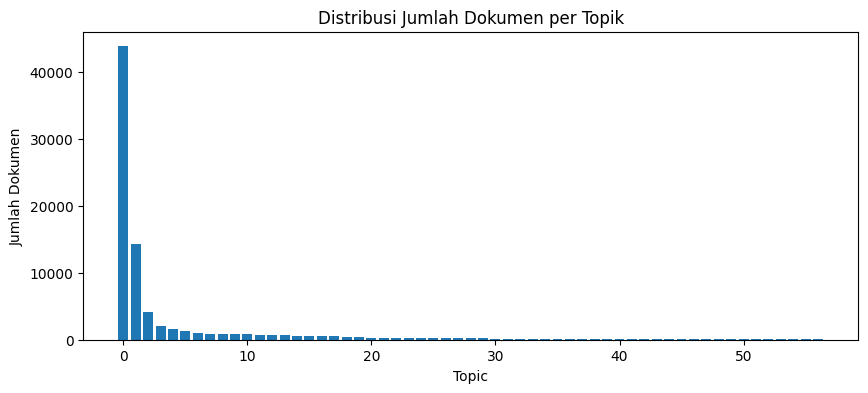

Rasio outlier (topic -1): 9.71%
Topik 0: coherence sederhana = 0.45
Topik 24: coherence sederhana = 0.23
Topik 17: coherence sederhana = 0.36
Topik 28: coherence sederhana = 0.48
Topik 1: coherence sederhana = 0.34
Topik 22: coherence sederhana = 0.30
Topik 2: coherence sederhana = 0.52
Topik 23: coherence sederhana = 0.36
Topik 4: coherence sederhana = 0.51
Topik 13: coherence sederhana = 0.41
Topik 8: coherence sederhana = 0.64
Topik 39: coherence sederhana = 0.40
Topik 11: coherence sederhana = 0.33
Topik 31: coherence sederhana = 0.42
Topik 10: coherence sederhana = 0.25
Topik 3: coherence sederhana = 0.51
Topik 15: coherence sederhana = 0.12
Topik 46: coherence sederhana = 0.36
Topik 47: coherence sederhana = 0.77
Topik 7: coherence sederhana = 0.52
Topik 40: coherence sederhana = 0.16
Topik 9: coherence sederhana = 0.42
Topik 32: coherence sederhana = 0.35
Topik 12: coherence sederhana = 0.55
Topik 25: coherence sederhana = 0.36
Topik 19: coherence sederhana = 0.45
Topik 30: cohe

In [39]:
# 1. Distribusi jumlah dokumen per topik
plt.figure(figsize=(10,4))
plt.bar(topic_labels, counts)
plt.xlabel("Topic")
plt.ylabel("Jumlah Dokumen")
plt.title("Distribusi Jumlah Dokumen per Topik")
plt.tight_layout()
plt.savefig("Notebooks/Result/indobertopic/min_cluster_size_50/distribusi_dokumen_per_topik.png")
plt.show()

# 2. Rasio outlier (topic -1)
outlier_ratio = topic_counts.get(-1, 0) / len(topics)
print(f"Rasio outlier (topic -1): {outlier_ratio:.2%}")

# 3. Coherence sederhana: rata-rata kemunculan kata kunci topik di dokumen topik tsb
def simple_coherence(topic_num, n_words=10):
    topic_words = [w for w, _ in topic_model.get_topic(topic_num)[:n_words]]
    idxs = [i for i, t in enumerate(topics) if t == topic_num]
    if not idxs:
        return 0
    docs_topic = [preprocessed_tweets[i] for i in idxs]
    scores = []
    for word in topic_words:
        count = sum(word in doc for doc in docs_topic)
        scores.append(count / len(docs_topic))
    return np.mean(scores)

coherences = []
for t in topic_labels:
    coh = simple_coherence(t)
    coherences.append(coh)
    print(f"Topik {t}: coherence sederhana = {coh:.2f}")

print(f"\nRata-rata coherence sederhana semua topik: {np.mean(coherences):.2f}")

# 4. Evaluasi kualitatif: tampilkan kata kunci (setelah filter stopwords) dan contoh tweet untuk beberapa topik
# Load keywords hasil filter stopwords
import pandas as pd
keywords_filtered = pd.read_csv("Notebooks/Result/indobertopic/min_cluster_size_50/after_stopwords/topic_keywords.csv")
keywords_dict = dict(zip(keywords_filtered['topic'], keywords_filtered['keywords']))

for t in topic_labels[:5]:
    print(f"\nTopik {t}:")
    print("Kata kunci (tanpa stopwords):", keywords_dict.get(t, "(tidak tersedia)"))
    idxs = [i for i, topic in enumerate(topics) if topic == t][:2]
    for idx in idxs:
        print(f"Contoh tweet: {preprocessed_tweets[idx]}")

## 7. Visualisasi Cluster Topik
Visualisasi distribusi cluster topik dalam 2D menggunakan UMAP untuk melihat pemisahan antar topik.

C:\Users\Akhnafal\AppData\Local\Temp\ipykernel_15132\4046482556.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



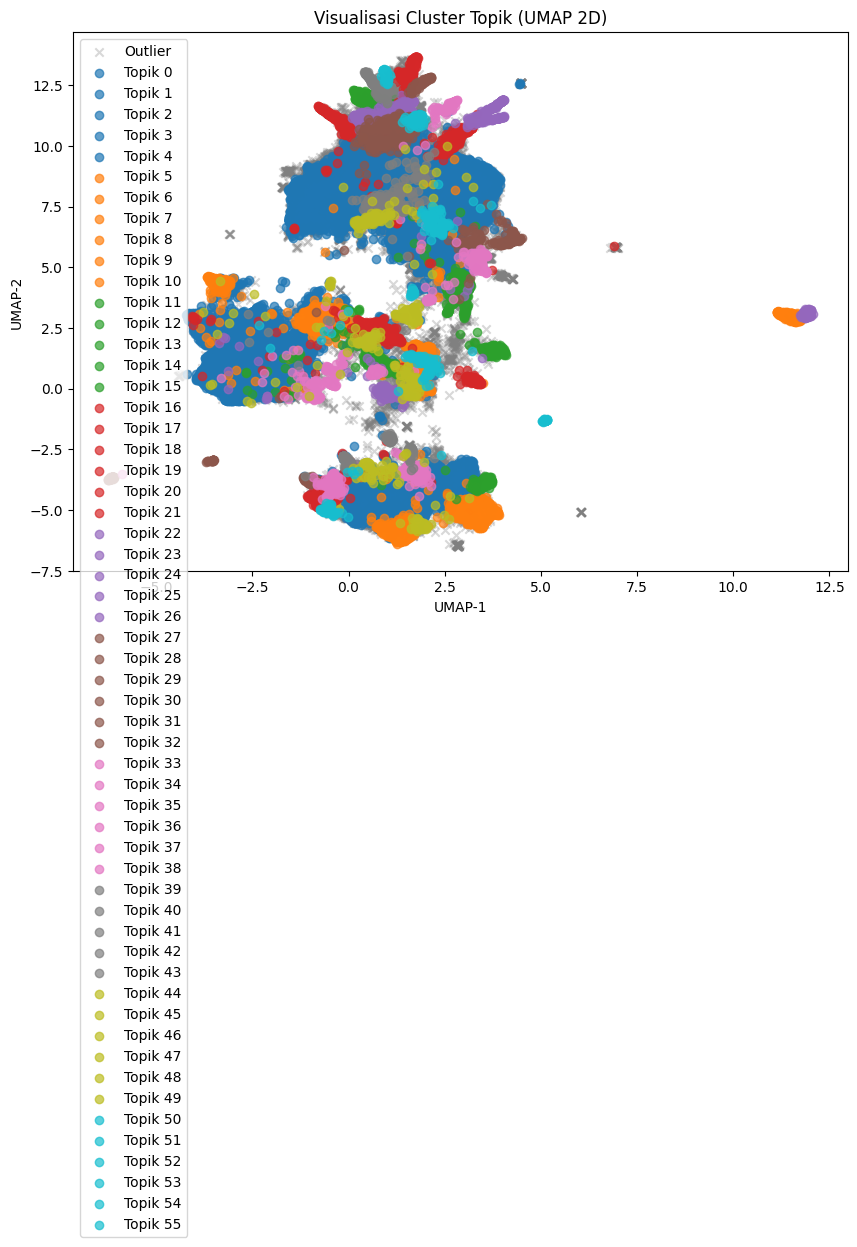

In [ ]:
# Visualisasi cluster topik dalam 2D menggunakan UMAP
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np

# Proyeksikan embedding ke 2D
umap_2d = UMAP(n_components=2, random_state=42)
embeddings_2d = umap_2d.fit_transform(embeddings)

plt.figure(figsize=(10,7))
unique_topics = np.unique(topics)
colors = plt.cm.get_cmap('tab10', len(unique_topics))
for i, topic_num in enumerate(unique_topics):
    if topic_num == -1:
        # Outlier topic
        plt.scatter(embeddings_2d[topics==topic_num,0], embeddings_2d[topics==topic_num,1], 
                    color='grey', alpha=0.3, label='Outlier', marker='x')
    else:
        plt.scatter(embeddings_2d[topics==topic_num,0], embeddings_2d[topics==topic_num,1], 
                    color=colors(i), alpha=0.7, label=f"Topik {topic_num}")
plt.legend()
plt.title("Visualisasi Cluster Topik (UMAP 2D)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

## 8. Sentimen per Topik

In [24]:
# # Analisis Sentimen per Topik
# from transformers import pipeline

# # Load pipeline IndoBERT Sentiment (pastikan sudah install modelnya, misal: "indobenchmark/indobert-base-p1")
# sentiment_analyzer = pipeline("sentiment-analysis", model="indobenchmark/indobert-base-p1", tokenizer="indobenchmark/indobert-base-p1")

# def get_sentiment_label(result):
#     label = result[0]['label'].lower()
#     if 'positif' in label:
#         return 'positif'
#     elif 'negatif' in label:
#         return 'negatif'
#     else:
#         return 'netral'

# def safe_sentiment(tweet, max_len=300):
#     # Potong tweet jika terlalu panjang (karakter, bukan token)
#     tweet = tweet[:max_len]
#     try:
#         return get_sentiment_label(sentiment_analyzer(tweet))
#     except Exception as e:
#         print(f"Error on tweet: {tweet[:100]}... ({e})")
#         return 'unknown'

# sentiments = [safe_sentiment(tweet) for tweet in preprocessed_tweets]
# df_topic['sentiment'] = sentiments

# # Distribusi sentimen per topik
# sentiment_dist = df_topic.groupby(['topic', 'sentiment']).size().unstack(fill_value=0)
# sentiment_dist.plot(kind='bar', stacked=True, figsize=(10,5))
# plt.title('Distribusi Sentimen per Topik')
# plt.xlabel('Topik')
# plt.ylabel('Jumlah Tweet')
# plt.show()

# # Tampilkan contoh tweet per sentimen untuk beberapa topik
# for t in topic_labels[:5]:
#     print(f"\nTopik {t}:")
#     for sent in ['positif', 'negatif', 'netral']:
#         sample = df_topic[(df_topic['topic']==t) & (df_topic['sentiment']==sent)].head(1)
#         if not sample.empty:
#             print(f"  Sentimen {sent}: {sample.iloc[0]['tweet']}")
#         else:
#             print(f"  Sentimen {sent}: (tidak ada contoh)")